In [1]:
import datetime
import numpy as np
import pandas
import json
from pathlib import Path
import glob
import pandas as pd 
from matplotlib.dates import HourLocator, DateFormatter
import matplotlib.pyplot as plt

In [7]:
datapath = Path.cwd().parent.joinpath('data') 
data_files = glob.glob(str(datapath)+'/*')
data_files[-5:]

['/home/thomas/Projects/citibike_stations/data/citibike_stations_2020_08_15_03_50_29.json',
 '/home/thomas/Projects/citibike_stations/data/citibike_stations_2020_08_14_13_50_24.json',
 '/home/thomas/Projects/citibike_stations/data/citibike_stations_2020_08_15_07_50_24.json',
 '/home/thomas/Projects/citibike_stations/data/citibike_stations_2020_08_14_18_50_26.json',
 '/home/thomas/Projects/citibike_stations/data/citibike_stations_2020_08_15_09_50_28.json']

In [3]:
def merge_dict(old_dict, new_dict):    
    for station, dock_timedict in new_dict.items():
        for dock_time, numdict in dock_timedict.items():
        
            if not old_dict.get(station):
                old_dict[station] = {dock_time:numdict}
        
            elif dock_time not in old_dict[station]:
                old_dict[station] = {**old_dict[station], dock_time:numdict}  

    return old_dict
 
data_dict = {}
for file in data_files:
    with open(file, "r") as read_file:
        file_data = json.load(read_file) 
        data_dict = merge_dict(data_dict, file_data) 

In [4]:
dict_of_df = {k: pd.DataFrame(v) for k,v in data_dict.items()}
df = pd.concat(dict_of_df, axis=1).transpose() 

df.reset_index(level=[0,1], inplace=True)
df['level_1'] = df.level_1.apply(lambda x: datetime.datetime.fromtimestamp(int(x)) )

df.rename(columns={'level_0':'station', 'level_1':'timestamp'}, inplace=True)

bool_active = df['timestamp'] > np.datetime64('2020-01-01 12:00:00')
df = df[bool_active]

df.head()

,station,timestamp,num_bikes_available,num_ebikes_available
1,79,2020-08-14 13:45:58,10,1
2,79,2020-08-14 13:58:23,9,0
3,79,2020-08-14 14:17:25,8,0
4,79,2020-08-14 14:27:12,9,1
5,79,2020-08-14 14:30:37,9,0


(18488.5, 18490.5)

<Figure size 432x288 with 0 Axes>

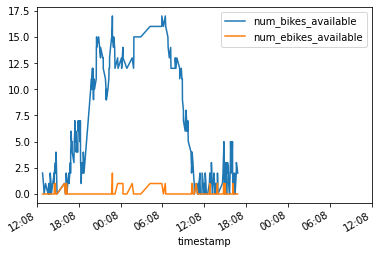

In [9]:
station_code = '3671' # 81st and 2nd
# station_code = '3370' # 78th and 2nd
# station_code = '3131' # 68th and 1st 

bool_station = df['station'] == station_code# '79'

plt.figure()
ax = df[bool_station].plot(x='timestamp')
 
ax.xaxis.set_major_locator(HourLocator(interval=6)) # tick every two hours
ax.xaxis.set_major_formatter(DateFormatter('%H:%m'))

ax.set_xlim([
    np.datetime64('2020-08-14 12:00:00'),
    np.datetime64('2020-08-16 12:00:00')])

3671
3370
3131


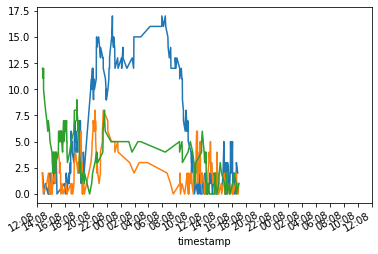

In [10]:
fig, ax = plt.subplots(1,1)

station_list = ['3671','3370','3131']
# station_list = ['3671']
# for station in df['station'].unique():

for station in station_list:
    bool_station = df['station'] == station
    df[bool_station].plot(ax=ax, x='timestamp', y='num_bikes_available', legend=False)
    print(station)

ax.set_xlim([
    np.datetime64('2020-08-14 12:00:00'),
    np.datetime64('2020-08-16 12:00:00')])
 
ax.xaxis.set_major_locator(HourLocator(interval=2)) # tick every two hours
ax.xaxis.set_major_formatter(DateFormatter('%H:%m'))
